In [1]:
import os
import pickle
import numpy as np 
from astropy.io import fits
import matplotlib.pylab as plt 
import pandas as pd 


plt.rc('text', usetex=True) # - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
fits_image = fits.open('./data/catalogue/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

In [3]:
rednames = ['Z_B', 'Z_B_MIN', 'Z_B_MAX']
redshifts = np.asarray([data[rednames[i]] for i in range(len(rednames))]).T
df_redshifts = pd.DataFrame(redshifts, columns = rednames, dtype = np.float16)

In [4]:
df_redshifts.head()

,Z_B,Z_B_MIN,Z_B_MAX
0,0.709961,0.449951,1.320312
1,0.439941,0.399902,0.459961
2,1.080078,1.000000,1.160156
3,0.540039,0.389893,0.839844
4,1.009766,0.939941,1.059570


In [5]:
bins = [[0.1, 0.3], [0.3, 0.5], [0.5, 0.7], [0.7, 0.9], [0.9, 1.2]]

# Our Method

In [6]:
labels = np.zeros(df_redshifts.shape[0], dtype = int)

In [7]:
for label, binlabel in enumerate(bins):
    labels[(df_redshifts['Z_B'].values > binlabel[0]) & (df_redshifts['Z_B'].values <= binlabel[1])] = label + 1

In [8]:
df_redshifts['label'] = labels

In [9]:
df_redshifts.head()

,Z_B,Z_B_MIN,Z_B_MAX,label
0,0.709961,0.449951,1.320312,4
1,0.439941,0.399902,0.459961,2
2,1.080078,1.000000,1.160156,5
3,0.540039,0.389893,0.839844,3
4,1.009766,0.939941,1.059570,5


In [63]:
def generate_samples(df_redshifts, zbins, nsamples, label):
    """
    Generate samples of the tomographic redshift distributions based on the BPZ values. 
    
    Args:
        df_redshifts (pd.DataFrame): a dataframe containing the columns Z_B, Z_B_MIN, Z_B_MAX, label
        zbins (np.ndarray): an array of the centres of the fine bins 
        nsamples (int): the number of samples we want to draw
        label (int): the label for the tomographic bin
    """
    tomo_bin = df_redshifts[df_redshifts['label'] == label]
    tomo_bin_min = tomo_bin['Z_B_MIN'].values.reshape(-1,1)
    tomo_bin_max = tomo_bin['Z_B_MAX'].values.reshape(-1,1)
    nobj = tomo_bin.shape[0]
    samples = np.random.uniform(tomo_bin_min, tomo_bin_max, size = (nobj, nsamples)) # nobj x nsamples
    nz_samples = []
    for i in range(nsamples):
        nz_samples.append(np.histogram(samples[:,i], bins=zbins, density=True)[0])
    nz_mean = np.mean(nz_samples, axis = 0)
    nz_std = np.std(nz_samples, axis = 0)
    nz_samples = np.random.normal(nz_mean, nz_std, (nsamples, len(nz_mean))).T
    return nz_mean, nz_std, nz_samples

In [64]:
coarse_z = 0.05
zmin = 0.0 
zmax = 6.0

In [65]:
zbins = np.arange(zmin, zmax, coarse_z)
zmid = zbins[0:-1] + coarse_z/2

In [93]:
nz_mean_1, nz_std_1, nz_samples_1 = generate_samples(df_redshifts, zbins, nsamples = 1000, label = 1)
nz_mean_2, nz_std_2, nz_samples_2 = generate_samples(df_redshifts, zbins, nsamples = 1000, label = 2)
nz_mean_3, nz_std_3, nz_samples_3 = generate_samples(df_redshifts, zbins, nsamples = 1000, label = 3)
nz_mean_4, nz_std_4, nz_samples_4 = generate_samples(df_redshifts, zbins, nsamples = 1000, label = 4)
nz_mean_5, nz_std_5, nz_samples_5 = generate_samples(df_redshifts, zbins, nsamples = 1000, label = 5)

In [94]:
grouping_mean = {'redshifts': zmid,
                'heights': {'BIN1': nz_mean_1,
                            'BIN2': nz_mean_2,
                            'BIN3': nz_mean_3,
                            'BIN4': nz_mean_4,
                            'BIN5': nz_mean_5}}

grouping_samples = {'redshifts': zmid, 
                   'heights': {'BIN1': nz_samples_1,
                               'BIN2': nz_samples_2,
                               'BIN3': nz_samples_3,
                               'BIN4': nz_samples_4,
                               'BIN5': nz_samples_5}}

In [96]:
def pickle_save(file: list, folder: str, fname: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder, exist_ok=True)

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        pickle.dump(file, dummy)

In [97]:
pickle_save(grouping_mean, 'nz_samples', 'grouping_mean')
pickle_save(grouping_samples, 'nz_samples', 'grouping_samples')

In [98]:
def normalize_heights(redshifts, heights):
    """
    Given the centres of the fine bins and the heights, we normalise the redshift distributions. 
    
    Args:
        redshifts (np.ndarray): the centre of the fine bins 
        heights (np.ndarray): the heights of the redshift distribution.
    """
    record_h = []
    redshifts = np.concatenate([np.zeros(1), redshifts])
    for i in range(len(heights)):
        height_i = np.concatenate([np.zeros(1), heights[i]])
        normalisation = np.trapz(height_i, redshifts)
        height_i /= normalisation
        record_h.append(height_i)
    record_h = np.array(record_h)
    return redshifts, record_h

In [99]:
redshifts, heights = normalize_heights(zmid, [nz_mean_1, nz_mean_2, nz_mean_3, nz_mean_4, nz_mean_5])

In [16]:
def kids_nz(fname = 'kids_1000'):
    # load the fits file
    data_tables = fits.open(f'data/cosmology/{fname}.fits')

    # extract the n(z) distribution
    nofz = data_tables['NZ_SOURCE'].data

    # get the redshifts
    redshifts = np.concatenate((np.zeros(1), nofz['Z_MID']))

    # heights for the n(z) distribution
    heights = []

    for zbin in range(5):
        hist_pz = nofz['BIN{:}'.format(zbin + 1)]
        heights += [np.concatenate((np.zeros(1), hist_pz))]
    heights = np.asarray(heights)
    
    for i in range(5):
        heights[i] /= np.trapz(heights[i], redshifts)
    return redshifts, heights

kids_z, kids_h = kids_nz('kids_1000')

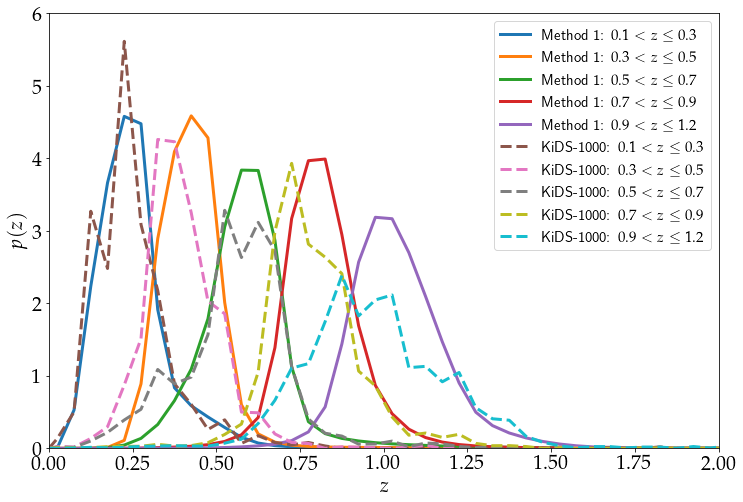

In [34]:
plt.figure(figsize = (12, 8))
for i in range(5):
    plt.plot(redshifts, heights[i], lw = 3, label = f'Method 1: ${bins[i][0]}<z\leq {bins[i][1]}$')
for i in range(5):
    plt.plot(kids_z, kids_h[i], lw = 3, linestyle = '--', label = f'KiDS-1000: ${bins[i][0]}<z\leq {bins[i][1]}$')
plt.xlim(zmin, 2.0)
plt.ylim(0.0, 6.0)
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()